# Restaurant Rating prediction


По ходу задачи:

Прокачаем работу с pandas
Научимся работать с Kaggle Notebooks
Поймем как делать предобработку различных данных
Научимся работать с пропущенными данными (Nan)
Познакомимся с различными видами кодирования признаков
Немного попробуем Feature Engineering (генерировать новые признаки)
И совсем немного затронем ML
И многое другое...
И самое важное, все это вы сможете сделать самостоятельно!
Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!
Вы можете использовать его как основу для построения своего решения.

что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.
baseline создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь)

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат. Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# IMPORT

In [1]:
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics  # инструменты для оценки точности модели
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import lognorm
import re
from scipy.stats import ttest_ind
from itertools import combinations
from sklearn.preprocessing import StandardScaler
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Импортируем необходимые библиотеки:

# Загружаем специальный удобный инструмент для разделения датасета:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Data

In [4]:
#DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
DATA_DIR = 'C:\\Users\\user\\Documents\\DataScience\\PYTHON\\module_3\\data\\'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


Данные загрузились корректно, можно приступать к работе

In [9]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Загрузилось 11 столбцов.

4 числовых столбца - Ranking,Number of Reviews,sample,Rating

7 строковых столбцов -Restaurant_id, City, Cuisine Style, Price Range,Reviews,URL_TA,ID_TA

Подробнее по признакам:

City: Город

Cuisine Style: Кухня

Ranking: Ранг ресторана относительно других ресторанов в этом городе

Price Range: Цены в ресторане в 3 категориях

Number of Reviews: Количество отзывов

Reviews: 2 последних отзыва и даты этих отзывов

URL_TA: страница ресторана на 'www.tripadvisor.com'

ID_TA: ID ресторана в TripAdvisor

Rating: Рейтинг ресторана

In [11]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
35697,id_375,Munich,"['Chinese', 'Asian']",377.0,$$ - $$$,81.0,"[['Best Hot Pot in Munich', 'Authentic, but ex...",/Restaurant_Review-g187309-d8566719-Reviews-Re...,d8566719,1,4.0
28205,id_8126,Madrid,NaN,8133.0,NaN,2.0,"[['Disapointing Lunch'], ['06/06/2017']]",/Restaurant_Review-g187514-d12535620-Reviews-T...,d12535620,1,2.5
26008,id_8661,Paris,"['French', 'European']",8663.0,$$$$,53.0,"[['Small and cozy restaurant, very happy we f....",/Restaurant_Review-g187147-d1422361-Reviews-Ca...,d1422361,1,3.5
37880,id_647,Bratislava,NaN,648.0,NaN,2.0,"[[], []]",/Restaurant_Review-g274924-d4770079-Reviews-Pa...,d4770079,1,4.0
40422,id_5924,London,"['American', 'Vegetarian Friendly', 'Halal', '...",5933.0,$$ - $$$,101.0,"[['Meaty meal', 'Great Burgers, reasonable pri...",/Restaurant_Review-g186338-d7804189-Reviews-Sa...,d7804189,1,3.5


# Обработка признаков
Я принял решение не разделять этапы "Cleaning and Preparing Data" и "EDA", а проводить их сразу последовательно к каждому признаку. Это объясняется тем что в ходе обработки признаков на их основе буду сразу генерировать новые и их исследовать.

Стандартизируем названия столбцов для удобстваработы

In [12]:
data.rename(columns={'Cuisine Style': 'Cuisine_style',
                     'Price Range': 'Price_range',
                     'Number of Reviews': 'Number_of_reviews',
                     'sample': 'Sample'}, inplace=True)
data.columns

Index(['Restaurant_id', 'City', 'Cuisine_style', 'Ranking', 'Price_range',
       'Number_of_reviews', 'Reviews', 'URL_TA', 'ID_TA', 'Sample', 'Rating'],
      dtype='object')

In [13]:
pd.isnull(data).sum()

Restaurant_id            0
City                     0
Cuisine_style        11590
Ranking                  0
Price_range          17361
Number_of_reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
Sample                   0
Rating                   0
dtype: int64

1)Пропуски в "Cuisine_style" будут обработаны позднее т.к. данный параметр содержит список кухонь и я намерен создать из него дамми-признаки

2)Пропуски в "Number_of_reviews" могут являться дополнительным признаком. Буду делать дополнительный признак показывающий отсутствие отзывов. А на текущем этапе заполню пропуски нулями. Отсутствие отзыва может быть связано с тем , что ресторан малоизвестен или он еще недавно на сайте и его не успели посетить

3) Пропуски в "Price_range" возможно как то коррелируют с пропусками "Number_of_reviews", но их ощутимо больше. Я принял решение что пропуски в данном параметре буду заменять медианным значением цены в ресторане того города, в котором находится ресторан. Делать это буду позднее при детальном анализе признаков.

## Общие функции
Я выделил отдельно общие функции которые буду применять.
Функций будет естественно больше но из-за локальности их применения я не стал их выносить в общий блок

In [14]:
'''функция obj_describe для описания параметров типа object.
Выводит информацию о :
1)пропусках данных
2)количестве встречающихся значений
3)Строит boxplot для оценки влияния признака на распределение целевой переменной'''


def obj_describe(data, column):
    print('пустых значений в колонке ', column,
          " : ", data.loc[:, column].isnull().sum())
    print('Значения в колонке: ', pd.DataFrame(
        data.loc[:, column].value_counts()))
    # график строим только для тренировочных данных чтобы по нему опре
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x=column, y='Rating', data=data)


'''функция num_value_analiz для анализа основных числовых показателей
Выводит информацию о:
1)min
2)25-й перцентиль
3)медиана
4)среднее
5)max
6)IQR
7)Границы выбросов
'''


def num_value_analiz(data, column):
    low = data.loc[:, column].min()
    median = data.loc[:, column].median()
    mean = data.loc[:, column].mean()
    hight = data.loc[:, column].max()
    IQR = data.loc[:, column].quantile(
        0.75) - data.loc[:, column].quantile(0.25)
    perc25 = data.loc[:, column].quantile(0.25)
    perc75 = data.loc[:, column].quantile(0.75)

    print('min : {} \n\r'.format(low),
          '25-й перцентиль: {} \n\r'.format(perc25),
          'медиана: {} \n\r'.format(median),
          'среднее: {} \n\r'.format(mean),
          'max : {} \n\r'.format(hight),
          '75-й перцентиль: {} \n\r'.format(perc75),
          "IQR: {} \n\r".format(IQR),
          "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

## 1.Restaurant_id 
идентификатор ресторана менять я никак не буду, пропусков в нем нет, но осмотреть его необходимо.

1) Создадим новый признак Franchise который будет показывать относится ресторан к сети или нет

In [15]:
data.Restaurant_id.value_counts()

id_633      19
id_871      19
id_436      19
id_227      19
id_430      18
            ..
id_6448      1
id_15688     1
id_9065      1
id_15038     1
id_14187     1
Name: Restaurant_id, Length: 13094, dtype: int64

In [16]:
s = data.Restaurant_id.value_counts()
multiple_id = s[s > 1]

In [17]:
data[data['Restaurant_id'] == 'id_633'].head(5)

,Restaurant_id,City,Cuisine_style,Ranking,Price_range,Number_of_reviews,Reviews,URL_TA,ID_TA,Sample,Rating
633,id_633,Stockholm,['Indian'],1261.0,NaN,9.0,"[['One more Indian Restaurant', 'Tiny and nice...",/Restaurant_Review-g189852-d8341999-Reviews-Fo...,d8341999,0,0.0
10836,id_633,Milan,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",635.0,$$ - $$$,743.0,[['Sunshine of Italian pizza in Milan on a we....,/Restaurant_Review-g187849-d7660183-Reviews-Br...,d7660183,1,3.5
12927,id_633,Budapest,['Vegetarian Friendly'],634.0,$,18.0,"[['Good qualitybreakfast and lovely venue', 'G...",/Restaurant_Review-g274887-d12327467-Reviews-F...,d12327467,1,4.5
14359,id_633,Rome,"['Italian', 'Pizza', 'Fast Food', 'Mediterrane...",634.0,$,600.0,"[['Cheap, delicious, good service, quick', 'Gr...",/Restaurant_Review-g187791-d3190881-Reviews-Re...,d3190881,1,4.5
14864,id_633,Munich,"['Peruvian', 'Latin', 'South American', 'Veget...",640.0,$$ - $$$,173.0,"[['Very good but service', 'Nice!'], ['05/13/2...",/Restaurant_Review-g187309-d1674728-Reviews-Na...,d1674728,1,4.0


Так же добавим признак franchise который будет показывать сетевой это ресторан и ли нет.
1 - сетевой
0 - не сетевой

In [18]:
data['Franchise'] = data['Restaurant_id'].apply(
    lambda x: 1 if x in multiple_id else 0)

пустых значений в колонке  Franchise  :  0
Значения в колонке:     Franchise
1      37378
0       2622


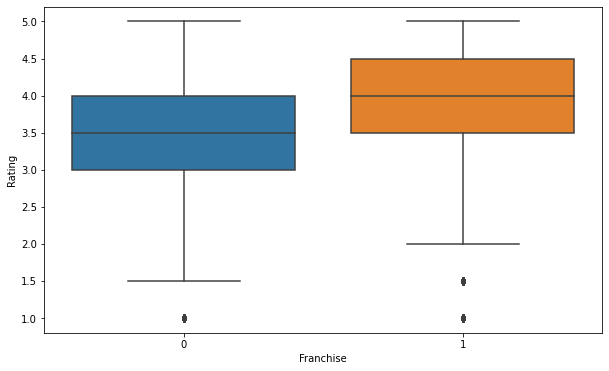

In [19]:
obj_describe(data[data['Sample'] == 1], 'Franchise')

## Вывод  Restaurant_id
Restaurant_id - Данный параметр без пропусков, визуальный осмотр показал что числовая часть данного параметра в большинстве случаев очень уж похожа на значение параметра Ranking.
На основе данного признака был сгенерирован новый признак - Franchise, показывающий относитеся ли ресторан к сетевым или нет.
Анализ нового признака показал его что для него имеется разница в плотности распределения целевой переменной Rating

## 2.Price Range
Цена в ресторане.
1)17361 пропусков(34%), много надо создать доп признак No_Price для сохранения информации что у ресторана не указана цена.

2)Значение строковые," $ , $$ - $$$,$$$$" при этом очевидно что относительно данного параметры уместна операция сравнения потому создам новый параметр Price_value заменив значениями 1,2,3 значения нашего параметра соответственно

3)В параметре тем не менее будут пропуски, пропуски для ресторана заменю медианным значением цены в ресторанах по тому городу, в котором расположен ресторан.
Вообще на этом этапе у нас по сути есть 3 кластера соответствующие ценовым диапазонам, и для ресторанов с неуказанной ценой можно провести классификацию. Но это отдельная задача, которая по сути может улучшить результат нашей главной задачи. Времени не так много чтобы этим заниматься потому может к этому вернусь после сдачи проекта

In [20]:
data.Price_range.value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price_range, dtype: int64

In [21]:
# Создаем новый признак No_Price
data['No_Price'] = pd.isna(data['Price_range']).astype('int64')
data[['No_Price', 'Price_range']][data['No_Price'] == 1]

,No_Price,Price_range
7,1,NaN
8,1,NaN
9,1,NaN
10,1,NaN
13,1,NaN
...,...,...
49988,1,NaN
49989,1,NaN
49990,1,NaN
49993,1,NaN


In [22]:
dict_values = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
data['Price_value'] = data['Price_range'].apply(
    lambda x: dict_values.get(x, x))
print(data[['Price_value', 'Price_range']])

       Price_value Price_range
0              2.0    $$ - $$$
1              2.0    $$ - $$$
2              2.0    $$ - $$$
3              3.0        $$$$
4              3.0        $$$$
...            ...         ...
49995          2.0    $$ - $$$
49996          2.0    $$ - $$$
49997          NaN         NaN
49998          2.0    $$ - $$$
49999          2.0    $$ - $$$

[50000 rows x 2 columns]


Заполним пропуски.
В ходе выполнения данного этапа и так стало ясно что медианная цена для 
каждого города - 2 , так же как и для всех ресторанов ,но т.к. в общем 
случае неправильно заменять пропуски медианной ценой по всем всем 
ресторанам(имхо) я все равно решил заменять медианной ценой по городу. 
Потому что города по достатку могут отличаться ,не понятно как установлена 
категория цен - она средняя для города или средняя во всем мире
функция возвращает среднее значение цены по городу

In [23]:
city_list = data.City.unique().tolist()
dict_city_mean_price = {}

for i in city_list:
    dict_city_mean_price[i] = data[data['City'] == i].Price_value.median()

dict_city_mean_price

{'Paris': 2.0,
 'Helsinki': 2.0,
 'Edinburgh': 2.0,
 'London': 2.0,
 'Bratislava': 2.0,
 'Lisbon': 2.0,
 'Budapest': 2.0,
 'Stockholm': 2.0,
 'Rome': 2.0,
 'Milan': 2.0,
 'Munich': 2.0,
 'Hamburg': 2.0,
 'Prague': 2.0,
 'Vienna': 2.0,
 'Dublin': 2.0,
 'Barcelona': 2.0,
 'Brussels': 2.0,
 'Madrid': 2.0,
 'Oslo': 2.0,
 'Amsterdam': 2.0,
 'Berlin': 2.0,
 'Lyon': 2.0,
 'Athens': 2.0,
 'Warsaw': 2.0,
 'Oporto': 2.0,
 'Krakow': 2.0,
 'Copenhagen': 2.0,
 'Luxembourg': 2.0,
 'Zurich': 2.0,
 'Geneva': 2.0,
 'Ljubljana': 2.0}

In [24]:
indexes = data[data.Price_value.isna()].index.tolist()
for i in indexes:
    data.loc[i, 'Price_value'] = dict_city_mean_price[data.loc[i, 'City']]

data[['Price_value', 'Price_range']]

,Price_value,Price_range
0,2.0,$$ - $$$
1,2.0,$$ - $$$
2,2.0,$$ - $$$
3,3.0,$$$$
4,3.0,$$$$
...,...,...
49995,2.0,$$ - $$$
49996,2.0,$$ - $$$
49997,2.0,NaN
49998,2.0,$$ - $$$


пустых значений в колонке  Price_value  :  0
Значения в колонке:       Price_value
2.0        32298
1.0         6279
3.0         1423


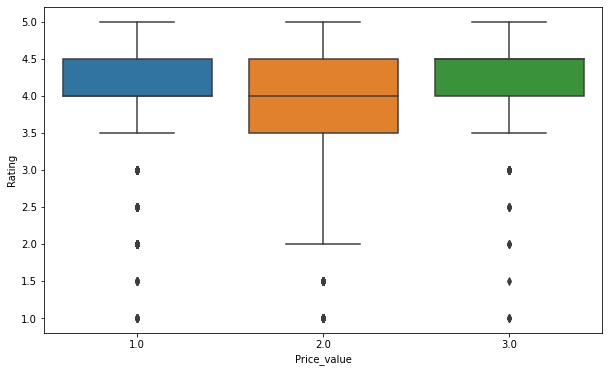

In [25]:
obj_describe(data[data['Sample'] == 1], 'Price_value')

In [26]:
num_value_analiz(data, 'Price_value')
# вообще подобный анализ  не совсем уместен т.к. 70% значений это 2
# смещение среднего относительно медианы в сторону 1 дает понять
# что дешевых ресторанов больше чем дорогих

min : 1.0 
 25-й перцентиль: 2.0 
 медиана: 2.0 
 среднее: 1.87932 
 max : 3.0 
 75-й перцентиль: 2.0 
 IQR: 0.0 
 Границы выбросов: [2.0, 2.0].


## Вывод  Price_range
в переменной очень много пропусков 17361 (34.7%). 

Чтобы не потерять информацию о пропусках создан новый критерий - No_Price 

Также создан новый признак числового кодирования цены - Price_value (низкая цена - 1, средняя цена -2 , высокая цена - 3). 

Пропуски заполнил медианой - средней ценой (двойкой).

## 3.Ranking 

<AxesSubplot:>

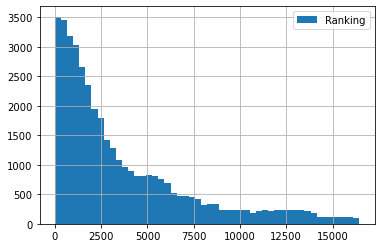

In [27]:
data[data['Sample'] == 1].Ranking.hist(legend=True, bins=50)

<AxesSubplot:>

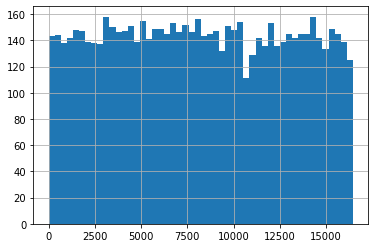

In [28]:
data[data['City'] == 'London']['Ranking'].hist(bins=50)

<AxesSubplot:>

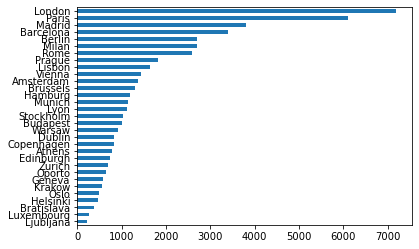

In [29]:
data['City'].value_counts(ascending=True).plot(kind='barh')

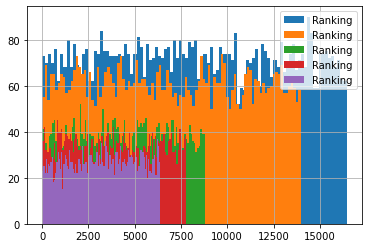

In [30]:
top_rest_city = (data.City.value_counts())[0:5].index
for x in top_rest_city:
    data['Ranking'][data['City'] == x].hist(bins=100, legend=True)
plt.show()

Видимо разница в количестве ресторанов в городе дает такое изменение. Значит для каждого города надо нормировать показатели. Потому что в Осло ресторанов ощутимо меньше чем в лондоне потому и мест в рейтинге будет меньше а следовательно как ни крути лучший ресторан в осло будет в рейтинге ниже чем какойнибудь средний лондонский реторан, хотя на деле может быть далеко не так

In [31]:
dict_mean_city_rank = {}
for i in city_list:
    dict_mean_city_rank[i] = round(data[data['City'] == i].Ranking.mean(), 4)
dict_mean_city_rank

{'Paris': 6938.5571,
 'Helsinki': 564.2316,
 'Edinburgh': 885.1302,
 'London': 8169.7074,
 'Bratislava': 462.4289,
 'Lisbon': 1867.3303,
 'Budapest': 1219.0617,
 'Stockholm': 1237.4821,
 'Rome': 2970.7331,
 'Milan': 3106.0278,
 'Munich': 1370.2978,
 'Hamburg': 1375.4098,
 'Prague': 2086.9796,
 'Vienna': 1711.2758,
 'Dublin': 972.128,
 'Barcelona': 3879.4227,
 'Brussels': 1541.9018,
 'Madrid': 4388.5164,
 'Oslo': 552.5697,
 'Amsterdam': 1591.5897,
 'Berlin': 3255.4177,
 'Lyon': 1303.9023,
 'Athens': 880.2139,
 'Warsaw': 1055.1935,
 'Oporto': 752.0343,
 'Krakow': 616.2671,
 'Copenhagen': 982.1477,
 'Luxembourg': 308.1597,
 'Zurich': 794.2803,
 'Geneva': 713.2271,
 'Ljubljana': 234.509}

о чем я и упомянул, о разнице ранга между большими и маленькими городами.
Для каждого города надо нормировать и центрировать

In [32]:
# посчитаем сколько ресторанов в каждом городе
rest_count = data.City.value_counts().to_dict()


def city_counter(city):
    return rest_count[city]


# создадим новый параметр
data['City_rest'] = data['City'].apply(city_counter)
print(data[['City', 'City_rest']])
print(rest_count)

             City  City_rest
0           Paris       6108
1        Helsinki        475
2       Edinburgh        745
3          London       7193
4      Bratislava        380
...           ...        ...
49995       Milan       2694
49996       Paris       6108
49997   Stockholm       1033
49998      Warsaw        925
49999       Milan       2694

[50000 rows x 2 columns]
{'London': 7193, 'Paris': 6108, 'Madrid': 3813, 'Barcelona': 3395, 'Berlin': 2705, 'Milan': 2694, 'Rome': 2589, 'Prague': 1816, 'Lisbon': 1647, 'Vienna': 1443, 'Amsterdam': 1372, 'Brussels': 1314, 'Hamburg': 1186, 'Munich': 1145, 'Lyon': 1126, 'Stockholm': 1033, 'Budapest': 1021, 'Warsaw': 925, 'Dublin': 836, 'Copenhagen': 819, 'Athens': 776, 'Edinburgh': 745, 'Zurich': 685, 'Oporto': 642, 'Geneva': 590, 'Krakow': 554, 'Oslo': 488, 'Helsinki': 475, 'Bratislava': 380, 'Luxembourg': 263, 'Ljubljana': 222}


In [33]:
# сделаем для каждого города средний ранг чтобы относительно него можно
# было сравнивать локально по городам
data['mean_City_rank'] = data['City'].apply(lambda x: dict_mean_city_rank[x])

In [34]:
# делаем для каждого ресторана новый локальный ранг
# data['norming_rank'] = (data['Ranking'] - data['mean_City_rank']) / data['City_rest']
data['norming_rank'] = data['Ranking'] / data['City_rest']

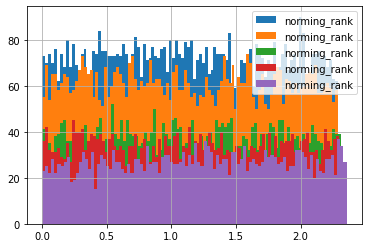

In [35]:
top_rest_city = (data.City.value_counts())[0:5].index
for x in top_rest_city:
    data['norming_rank'][data['City'] == x].hist(bins=100, legend=True)
plt.show()

## Вывод Ranking
Нормировали и центрировали переменную по городам.

создали параметр norming_rank - нормированный , центрированный ранг ресторана

создали параметр City_rest - количество ресторанов в городе

создали параметр mean_City_rank - средний ранг в городе

## 4.City 

пустых значений в колонке  City  :  0
Значения в колонке:              City
London      5757
Paris       4897
Madrid      3108
Barcelona   2734
Berlin      2155
Milan       2133
Rome        2078
Prague      1443
Lisbon      1300
Vienna      1166
Amsterdam   1086
Brussels    1060
Hamburg      949
Munich       893
Lyon         892
Stockholm    820
Budapest     816
Warsaw       727
Dublin       673
Copenhagen   659
Athens       628
Edinburgh    596
Zurich       538
Oporto       513
Geneva       481
Krakow       443
Oslo         385
Helsinki     376
Bratislava   301
Luxembourg   210
Ljubljana    183


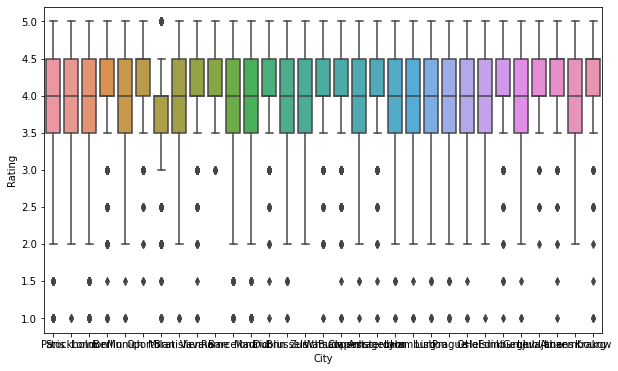

In [36]:
obj_describe(data[data['Sample'] == 1], 'City')

1)Данный параметр не имеет пропусков.
2)Так же городов не так много потому наличие/отсутствие ошибок написания вида "London" и "london" можно проверить методом "пристального взгляда". Тем не менее проведем небольшую доработку путем приведения всех названий к нижнему регистру.
3)Так же из боксплота видно что значение данного параметра имеет влияние на плотность распределения целевой переменной
4)Создадим новый параметр City_rest показывающий количество ресторанов в городе, в котором находится целевой ресторан. Признак числовой потому сразу его проанализируем
5)На основе признака City сгенерируем новые дамми-признаки

In [37]:
data.City = data.City.apply(lambda x: x.lower())
data.head(5)

,Restaurant_id,City,Cuisine_style,Ranking,Price_range,Number_of_reviews,Reviews,URL_TA,ID_TA,Sample,Rating,Franchise,No_Price,Price_value,City_rest,mean_City_rank,norming_rank
0,id_0,paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1,0,2.0,6108,6938.5571,2.122299
1,id_1,helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1,0,2.0,475,564.2316,0.223158
2,id_2,edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1,0,2.0,745,885.1302,1.087248
3,id_3,london,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,1,0,3.0,7193,8169.7074,0.232031
4,id_4,bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,1,0,3.0,380,462.4289,0.097368


<AxesSubplot:>

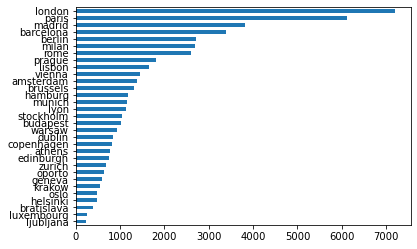

In [38]:
data['City'].value_counts(ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='Frequency'>

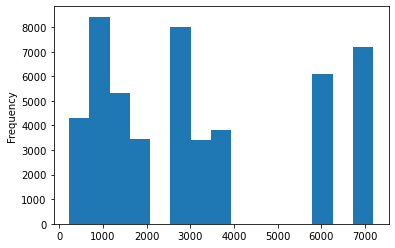

In [39]:
data.City_rest.plot(kind='hist', bins=15)

In [40]:
# сделаем анализ границ и расчитаем их точные значения
num_value_analiz(data, 'City_rest')
# построение гистограммы с обозначением выбросов считаю нецелесообразным т.к.
# Как мы видели из распределения количества ресторанов по городам,
# в европейских столицах как более богатых городах просто больше ресторанов))

min : 222 
 25-й перцентиль: 1145.0 
 медиана: 2694.0 
 среднее: 3196.6344 
 max : 7193 
 75-й перцентиль: 6108.0 
 IQR: 4963.0 
 Границы выбросов: [-6299.5, 13552.5].


По сути выбросов здесь и не может быть т.к. верхняя планка для данного параметра не установлена, а отрицательной быть не может.
Просто можем обратить внимание на то что медиана меньше среднего что по сути повторяет смысл графика с количеством ресторанов по городам. 

Признак City категорийальный потому на его основе сгенерируем новые дамми-признаки

In [41]:
data = pd.get_dummies(data, columns=['City', ], dummy_na=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   Cuisine_style      38410 non-null  object 
 2   Ranking            50000 non-null  float64
 3   Price_range        32639 non-null  object 
 4   Number_of_reviews  46800 non-null  float64
 5   Reviews            49998 non-null  object 
 6   URL_TA             50000 non-null  object 
 7   ID_TA              50000 non-null  object 
 8   Sample             50000 non-null  int64  
 9   Rating             50000 non-null  float64
 10  Franchise          50000 non-null  int64  
 11  No_Price           50000 non-null  int64  
 12  Price_value        50000 non-null  float64
 13  City_rest          50000 non-null  int64  
 14  mean_City_rank     50000 non-null  float64
 15  norming_rank       50000 non-null  float64
 16  City_amsterdam     500

## Вывод City
Данный параметр не имеет пропусков. Проведена небольшая косметическая обработка значений. 

Анализ влияния параметра на плотность распределения показал значимость данного параметра.

Был сгенерирован новый признак City_rest обозначающий количество ресторанов.

На основе параметра City были сгенерированны новые дамми-признаки для модели.

##  5.Cuisine_style

Применение моей функции не целесообразно т.к. для данных строковых значений слишком много комбинаций и требуется иная предобработка признака

In [42]:
data.Cuisine_style.value_counts()

['Italian']                                                        1332
['French']                                                         1019
['Spanish']                                                         860
['French', 'European']                                              503
['Cafe']                                                            500
                                                                   ... 
['Italian', 'Lebanese', 'Seafood', 'Mediterranean', 'Barbecue']       1
['Thai', 'Pub', 'Grill', 'Vegetarian Friendly']                       1
['Chinese', 'Asian', 'Italian', 'Vegetarian Friendly']                1
['Steakhouse', 'European', 'American', 'Gluten Free Options']         1
['Italian', 'Mexican', 'Pizza']                                       1
Name: Cuisine_style, Length: 10731, dtype: int64

В признаке 11590, а это около 20% от общего числа.  

1) Решил что создам новый признак "No_Cuisine_style" поскольку доля с пропусками достаточно велика и терять такую информацию не нужно и ведь вполне возможно что ресторан просто не добавил такую информацию о себе на ресурс.
1- стиль кухни отсутствует,0 - указан

2) Создадим новый признак "Cuisine_quant"- количество кухонь, представленных в ресторане

3) Необходимо заполнить пропуски, я решил заполнить их значением 'Other'

4) Видно, что в данном параметре хранится список, но в датафрейме он хранится строкой и потому взаимодействовать с ним как со списком не получится. и это надо исправить.

5) Кухни - по сути категориальный параметр потому надо сгенерировать новые параметры в виде принадлежности к кухне



In [43]:
# Создаем новый признак No_Cuisine_style
data['No_Cuisine_style'] = pd.isna(data['Cuisine_style']).astype('int64')
data[['No_Cuisine_style', 'Cuisine_style']][data['No_Cuisine_style'] == 1]

,No_Cuisine_style,Cuisine_style
7,1,NaN
10,1,NaN
13,1,NaN
18,1,NaN
20,1,NaN
...,...,...
49981,1,NaN
49983,1,NaN
49986,1,NaN
49988,1,NaN


пустых значений в колонке  No_Cuisine_style  :  0
Значения в колонке:     No_Cuisine_style
0             30717
1              9283


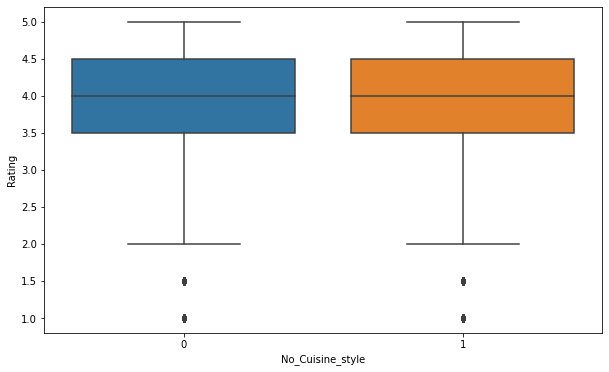

In [44]:
obj_describe(data[data['Sample'] == 1], 'No_Cuisine_style')

Видим, что наличие определенного стиля кухни(значение 0) не влияет на распределение целевого признака. Данная идея не обернулась усехом. Ну хоть показал знание FailFast, возможно))

In [45]:
# Создаем новый признак Cuisine_quant
# там где нет стиля кухни будет соответственно стоять 0
data['Cuisine_quant'] = data['Cuisine_style'].apply(
    lambda x: len(re.findall(r"'(\b.*?\b)'", str(x))))
data[['Cuisine_quant', 'Cuisine_style']][data['Cuisine_quant'] == 0]

,Cuisine_quant,Cuisine_style
7,0,NaN
10,0,NaN
13,0,NaN
18,0,NaN
20,0,NaN
...,...,...
49981,0,NaN
49983,0,NaN
49986,0,NaN
49988,0,NaN


<AxesSubplot:>

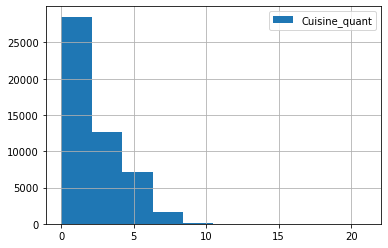

In [46]:
data.Cuisine_quant.hist(legend=True)

пустых значений в колонке  Cuisine_quant  :  0
Значения в колонке:      Cuisine_quant
0            9283
1            7264
2            6294
3            5306
4            4799
5            3606
6            2043
7            1022
8             283
9              76
10             19
11              3
21              1
13              1


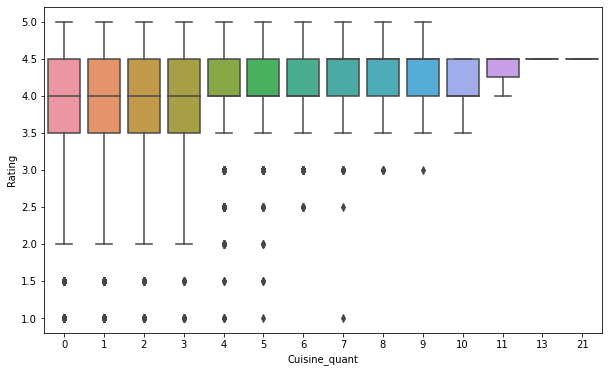

In [47]:
obj_describe(data[data['Sample'] == 1], 'Cuisine_quant')

Видим как отсутствие/наличие, а так же количество стилей кухни влияет на распределение рейтинга. Параметр числовой потому проведем более плотный анализ

In [48]:
num_value_analiz(data, 'Cuisine_quant')

min : 0 
 25-й перцентиль: 1.0 
 медиана: 2.0 
 среднее: 2.39352 
 max : 21 
 75-й перцентиль: 4.0 
 IQR: 3.0 
 Границы выбросов: [-3.5, 8.5].


Очевидно что имеются рестораны , которые по данному показателю считаются выбросом, но вполне вомзожно что это крайне разноплановый ресторан потому удалять его как выброс я не буду

In [49]:
print('всего кобинаций :', len(data['Cuisine_style'].unique().tolist()))
# крайне много уникальных комбинаций стилей, создание дамми-признаков
# по каждой комбинации считаю нецелесообразным
print('самые популярные стили', data.Cuisine_style.value_counts()[0:15])
print('самые уникальные стили', data.Cuisine_style.value_counts()[-16:])

всего кобинаций : 10732
самые популярные стили ['Italian']                     1332
['French']                      1019
['Spanish']                      860
['French', 'European']           503
['Cafe']                         500
['Pizza']                        454
['Italian', 'Pizza']             422
['Chinese']                      418
['European', 'Portuguese']       415
['Mediterranean']                311
['Bar', 'Pub']                   307
['Mediterranean', 'Spanish']     293
['Vegetarian Friendly']          276
['Indian']                       270
['Fast Food']                    263
Name: Cuisine_style, dtype: int64
самые уникальные стили ['French', 'Delicatessen', 'Bar', 'Mediterranean', 'European', 'Spanish', 'Vegetarian Friendly']                                    1
['Lebanese', 'Mediterranean', 'Middle Eastern', 'African', 'Halal', 'Vegetarian Friendly']                                          1
['International', 'Japanese', 'Mediterranean', 'Asian', 'Fusion', 'Vegeta

In [50]:
# Заполним пропуски
data['Cuisine_style'] = data['Cuisine_style'].fillna("['Other']")
data.Cuisine_style.value_counts()

['Other']                                                                                      11590
['Italian']                                                                                     1332
['French']                                                                                      1019
['Spanish']                                                                                      860
['French', 'European']                                                                           503
                                                                                               ...  
['Thai', 'Pub', 'Grill', 'Vegetarian Friendly']                                                    1
['Chinese', 'Asian', 'Italian', 'Vegetarian Friendly']                                             1
['Steakhouse', 'European', 'American', 'Gluten Free Options']                                      1
['Asian', 'Thai', 'Seafood', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']

In [51]:
# Обработаем значения признака
data['Cuisine_style'] = data['Cuisine_style'].str.findall(r"'(\b.*?\b)'")

In [52]:
# составим список всех уникальных кухонь
Trash_styles = data['Cuisine_style'].tolist()
Trash_styles
clear_styles = []
for style in Trash_styles:
    clear_styles.extend(style)
clear_styles = set(clear_styles)
print(clear_styles)

{'Diner', 'Polish', 'Delicatessen', 'Yunnan', 'Minority Chinese', 'Egyptian', 'Vietnamese', 'Croatian', 'Bar', 'Cambodian', 'Vegan Options', 'Latin', 'Persian', 'Central Asian', 'Israeli', 'Romanian', 'Seafood', 'Soups', 'Street Food', 'Gluten Free Options', 'Halal', 'Polynesian', 'Scottish', 'Armenian', 'Austrian', 'Contemporary', 'Pakistani', 'Venezuelan', 'Balti', 'Southwestern', 'Tunisian', 'Burmese', 'Indonesian', 'Sri Lankan', 'Healthy', 'Chinese', 'European', 'Tibetan', 'German', 'Latvian', 'Taiwanese', 'Danish', 'Australian', 'Grill', 'Singaporean', 'Native American', 'Portuguese', 'British', 'Azerbaijani', 'Czech', 'Pub', 'Barbecue', 'Turkish', 'Arabic', 'Jamaican', 'Asian', 'Cajun & Creole', 'Slovenian', 'Mongolian', 'Russian', 'Argentinean', 'Irish', 'Cuban', 'Georgian', 'International', 'Greek', 'Chilean', 'Eastern European', 'Kosher', 'Ethiopian', 'Ukrainian', 'Thai', 'Moroccan', 'Ecuadorean', 'Nepali', 'Canadian', 'Peruvian', 'Caribbean', 'Central American', 'Italian', 'K

In [53]:
# создадим дамми переменные по стилям кухни. Встроенную функцию get_dummies
# здесь использовать не получится, создадим свою
# у нас в параметре Cuisine_style для многих по сути указана комбинация
# стилей, создав признак по каждому отдельному стилю мы по сути учли это
def style_creator(style):
    data[style] = data['Cuisine_style'].apply(lambda x: 1 if style in x else 0)


for style in clear_styles:
    style_creator(style)

# и для примера посмотрим информацию для пары стилей
data[['Cuisine_style', 'Diner', 'German']][data['Diner'] == 1]
# визуальный осмотр показал что все получилось корректно

,Cuisine_style,Diner,German
140,"[Cafe, Mediterranean, Spanish, Diner]",1,0
198,"[Diner, Mediterranean, Spanish, Fusion]",1,0
228,"[Bar, Spanish, Contemporary, Diner]",1,0
312,"[Diner, Healthy, German, Cafe, Vegetarian Frie...",1,1
441,"[Fast Food, International, Contemporary, Diner...",1,0
...,...,...,...
49277,"[Diner, American]",1,0
49402,"[German, Cafe, Diner, Wine Bar, Soups]",1,1
49468,"[American, Fast Food, Diner]",1,0
49534,"[Mediterranean, Spanish, European, Diner]",1,0


## Вывод Cuisine_style
Создали признак No_Cuisine_style, к сожалению по графику  видно что он не влияет на плотность распределения целевой переменной.

Создали пораметр Cuisine_quant, показывающий количество стилей кухни в ресторане.

Заполнили пропуски .

Создали дамми переменные по стилю

## 6.Number of Reviews 
3200 пропущенных значений. Создадим новый признак для сохранения информации
про

<AxesSubplot:>

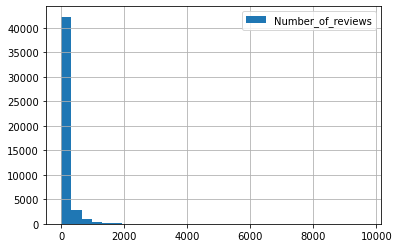

In [54]:
data.Number_of_reviews.hist(legend=True, bins=30)

In [55]:
num_value_analiz(data, 'Number_of_reviews')

min : 2.0 
 25-й перцентиль: 9.0 
 медиана: 33.0 
 среднее: 124.47119658119658 
 max : 9660.0 
 75-й перцентиль: 115.0 
 IQR: 106.0 
 Границы выбросов: [-150.0, 274.0].


Подавляющее большинство ресторанов имеет не особо большое количество отзывов.
Хоть и очевидно явное наличие выбросов исходя из значений квартилей и межквартильного расстояния,
тем не менее считаю , что явных выбросов здесь нет.
Максимальным количеством отзывов мы не ограничены, а отрицательного значения мы не наблюдаем

In [56]:
# Создаем новый признак No_Cuisine_style
data['No_reviews'] = pd.isna(data['Number_of_reviews']).astype('int64')
data[['No_reviews', 'Number_of_reviews']][data['No_Cuisine_style'] == 1]

,No_reviews,Number_of_reviews
7,1,NaN
10,0,306.0
13,0,30.0
18,0,2.0
20,0,8.0
...,...,...
49981,0,29.0
49983,0,2.0
49986,1,NaN
49988,1,NaN


пустых значений в колонке  No_reviews  :  0
Значения в колонке:     No_reviews
0       37457
1        2543


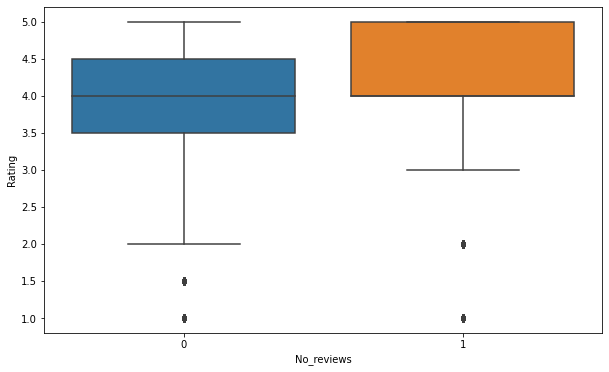

In [57]:
obj_describe(data[data['Sample'] == 1], 'No_reviews')

Видим , что ресторын с отсутствующими отзывами показывают выше рейтинг чем рестораны с отзывами. Оно и верно потому что чаще люди оставляют отзыв когда недовольны обслуживанием и в отзыве они высказывают свое впечатление)

Text(0, 0.5, 'Number_of_reviews')

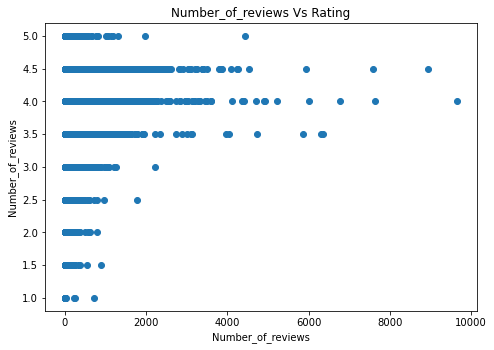

In [58]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(x=data[data['Sample'] == 1]['Number_of_reviews'],
             y=data[data['Sample'] == 1]['Rating'], marker='o')
axes.set_title('Number_of_reviews Vs Rating')
axes.set_xlabel('Number_of_reviews')
axes.set_ylabel('Number_of_reviews')

Вполне нормальная картина что ресторын со "средней" оценкой имеют наибольшее число отзывов 

In [59]:
# Я решил заполнить пропуски 0
data['Number_of_reviews'] = data['Number_of_reviews'].fillna(0)

## Вывод Number of Reviews
Пропуски заполнены

новый признак показывающий отсутствие отзыва - сгенерирован. Видно его влияение на распределение целевой переменной

## 7.Reviews 

In [60]:
print(data['Reviews'][0:2])

0                                             [[], []]
1    [['Very good reviews!', 'Fine dining in Hakani...
Name: Reviews, dtype: object


In [61]:
data['Reviews'][1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [62]:
pd.isnull(data['Reviews']).sum()

2

Параметр содержит 2 последних отзыва и даты их написания соответственно.
Так же видно что хоть и незаполненных значений всего 2, тем не менее есть другой "формат " пустого значения - [[], []]

In [63]:
len(data[data['Reviews'] == '[[], []]'])
# достаточно много строк без отзывов, будем обрабатывать это как пропуск оотзыва

8112

In [64]:
# Приведем пропуски к 1 виду
data['Reviews'] = data['Reviews'].fillna('[[], []]')

In [65]:
# создадим новый параметр No_reviews
data['No_reviews'] = (data['Reviews'] == '[[], []]').astype('float64')

из-за разных форматов пустых отзывов закрались сомнения в корректность остальных данных с отзывами.


In [66]:
# создаем новый параметр с датами
data['Review_dates'] = data['Reviews'].str.findall('\d+/\d+/\d+')

<AxesSubplot:>

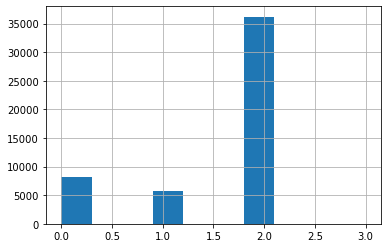

In [67]:
data['Review_dates'].apply(lambda x: len(x)).hist()
# 0 это наши пустые значения, 1 - извлеклась 1 дата

In [68]:
data[data['Review_dates'].apply(lambda x: len(x)) == 1]['Reviews']
# дата извлекалась корректно просто дата всего одна

12       [['You always feel very Welcome at this cozy.....
31                    [['Very good food'], ['09/24/2017']]
48                            [['Thomas'], ['01/06/2016']]
50       [['The best in Budapest so far'], ['03/05/2017']]
55       [['Coffee was fine - and as it says low price'...
                               ...                        
49972             [['Personal expirence'], ['10/27/2017']]
49974    [['Nice place to eat and chill'], ['08/29/2016']]
49983     [['Italian food, as in Italy!'], ['05/24/2015']]
49984          [['Good Cookies and more'], ['11/03/2016']]
49989             [['I love this place!'], ['08/24/2015']]
Name: Reviews, Length: 5680, dtype: object

In [69]:
data['Dates_count'] = data['Review_dates'].apply(lambda x: len(x))
num_value_analiz(data, 'Dates_count')
# есть строки с 3 датами

min : 0 
 25-й перцентиль: 1.0 
 медиана: 2.0 
 среднее: 1.56192 
 max : 3 
 75-й перцентиль: 2.0 
 IQR: 1.0 
 Границы выбросов: [-0.5, 3.5].


In [70]:
data[data['Dates_count'] == 3]['Review_dates']
# ,ошибки в заполнении, даты включали в текст отзыва. просто удалим первую дату

2221      [21/10/17, 12/22/2017, 10/19/2017]
3809     [30/5/2017, 04/13/2017, 05/30/2017]
19254     [3/1/2017, 06/02/2017, 01/03/2017]
33348    [29/9/2016, 09/30/2016, 08/25/2016]
Name: Review_dates, dtype: object

In [71]:
data['Dates_count'].Review_dates = data[data['Dates_count']
                                        == 3].Review_dates.apply(lambda x: x.pop(0))
data['Dates_count'] = data['Review_dates'].apply(lambda x: len(x))
num_value_analiz(data, 'Dates_count')

min : 0 
 25-й перцентиль: 1.0 
 медиана: 2.0 
 среднее: 1.56184 
 max : 2 
 75-й перцентиль: 2.0 
 IQR: 1.0 
 Границы выбросов: [-0.5, 3.5].


In [72]:
data.Dates_count.value_counts()

2    36206
0     8114
1     5680
Name: Dates_count, dtype: int64

пустых значений в колонке  Dates_count  :  0
Значения в колонке:     Dates_count
2        28973
0         6471
1         4556


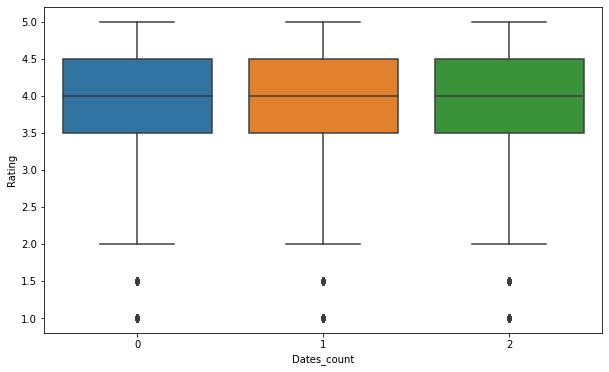

In [73]:
obj_describe(data[data['Sample'] == 1], 'Dates_count')

Видим что количество отзывов все таки не значимо для распределения целевой переменной.

Из дат я решил извлечь следующее:

1)количество дней от последнего отзыва до текущегог дня. Очевидно что база у нас не совсем новая, но представим что она новая. Ресторан у которого крайний отзыв был вчера и ресторан у которого крайний отзыв был 3 года назад очевидно отличаются) Во втором случае ресторан мог закрыться, либо он совсем не популярный и мало кто ходит.

2)Количество дней между отзывами. В среднем везде одинаковая доля людей оставляет отзыв о ресторане, соответвенно чем популярнее ресторан тем чаще ему будут попадаться клиенты, готовые оставить отзыв , а значи перерыв между отзывами будет меньше. В то время как у мало посещаемого ресторана перерыв соответственно будет больше.

3)Из логики второго пункта надо как то отделить рестораны у которых всего один отзыв. потому что значение 0 между отзывами здесь будет некорректно т.к. здесб чем меньше значение тем лучше. Более того по графику видно что рестораны без отзывов или с 1 отзывом одинаково распределены. Возможно стоит их объединить 1 параметром

In [74]:
def last_review(row):
    if row['Review_dates'] == []:
        return None
    return (pd.datetime.now() - pd.to_datetime(row['Review_dates']).max()).days


data['last_review'] = data.apply(last_review, axis=1)

data['last_review']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


0           NaN
1        1009.0
2         986.0
3        1008.0
4         944.0
          ...  
49995     998.0
49996     993.0
49997    1406.0
49998    1156.0
49999    1683.0
Name: last_review, Length: 50000, dtype: float64

In [75]:
num_value_analiz(data, 'last_review')

min : 926.0 
 25-й перцентиль: 1005.0 
 медиана: 1079.0 
 среднее: 1216.0453612185456 
 max : 5985.0 
 75-й перцентиль: 1263.0 
 IQR: 258.0 
 Границы выбросов: [618.0, 1650.0].


<AxesSubplot:>

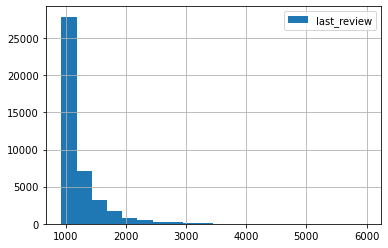

In [76]:
data.last_review.hist(legend=True, bins=20)

исходя из границ , выбросов получается достаточно много.Посмотрим сколько ресторанов попало в выбросы

In [77]:
IQR = data.last_review.quantile(0.75) - data.last_review.quantile(0.25)
perc25 = data.last_review.quantile(0.25)
perc75 = data.last_review.quantile(0.75)
low = perc25-1.5*IQR
hight = perc75+1.5*IQR

In [78]:
len(data[(data['last_review'] < low) | (data['last_review'] > hight)])

4014

В выбросы попало почти 4014 ресторанов, это почти 8%.
отделим рестораны с слишком старыми отзывами, может они уже закрылись

In [79]:
len(data[data['last_review'] > hight])
# жалко удалять столько данных

4014

In [80]:
data['last_review'] = data['last_review'].fillna(0)

In [81]:
def between_reviews(row):
    if row['Review_dates'] == []:
        return None
    return (pd.to_datetime(row['Review_dates']).max() - pd.to_datetime(row['Review_dates']).min()).days


data['between_reviews'] = data[data['Dates_count']
                               == 2].apply(between_reviews, axis=1)

data[['between_reviews', 'Dates_count', 'Review_dates']]

,between_reviews,Dates_count,Review_dates
0,NaN,0,[]
1,37.0,2,"[12/05/2017, 10/29/2017]"
2,22.0,2,"[12/28/2017, 12/06/2017]"
3,14.0,2,"[12/06/2017, 11/22/2017]"
4,15.0,2,"[02/08/2018, 01/24/2018]"
...,...,...,...
49995,34.0,2,"[12/16/2017, 11/12/2017]"
49996,9.0,2,"[12/21/2017, 12/12/2017]"
49997,3127.0,2,"[11/03/2016, 04/12/2008]"
49998,23.0,2,"[07/11/2017, 06/18/2017]"


In [82]:
num_value_analiz(data, 'between_reviews')

min : 0.0 
 25-й перцентиль: 20.0 
 медиана: 67.0 
 среднее: 142.54883168535602 
 max : 3296.0 
 75-й перцентиль: 173.0 
 IQR: 153.0 
 Границы выбросов: [-209.5, 402.5].


<AxesSubplot:>

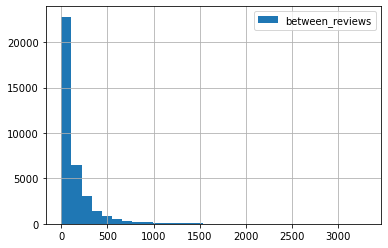

In [83]:
data.between_reviews.hist(legend=True, bins=30)

3296 дней между отзывами это плоховато...


In [84]:
IQR = data.between_reviews.quantile(0.75) - data.last_review.quantile(0.25)
perc25 = data.between_reviews.quantile(0.25)
perc75 = data.between_reviews.quantile(0.75)
low = perc25-1.5*IQR
hight = perc75+1.5*IQR
len(data[data['between_reviews'] > hight])

36206

хотя тут 70% попало в выбросы с по данному параметру.
я решил добавить признак отпределяющий что у ресторана был всего 1 отзыв

In [85]:
data['between_reviews'] = data['between_reviews'].fillna(0)

In [86]:
data['single_review'] = (data['Dates_count'] == 1).astype('float64')

пустых значений в колонке  single_review  :  0
Значения в колонке:       single_review
0.0          35444
1.0           4556


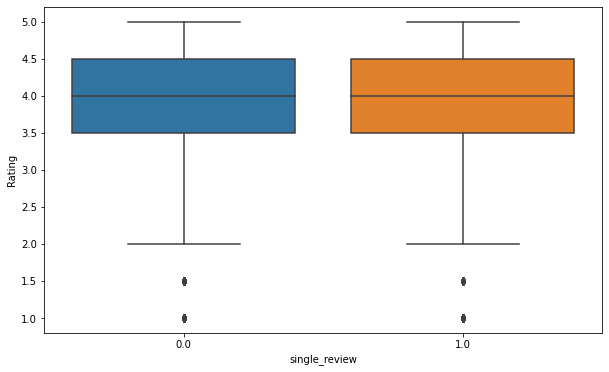

In [87]:
obj_describe(data[data['Sample'] == 1], 'single_review')

видим , что значения параметра single_review не влияет на распределение целевой переменной

## Вывод  Reviews
параметр содержит пропуски 2 видов, [[], []] и NaN , суммарно 8114.
Нан был заполнен  "[[], []]" для приведения значений к одному виду

Был сгенерирован новый признак No_reviews показывающий у каких ресторанов отсутствовали отзывы.

Был сгенерирован Review_dates - извлеченые даты из отзывов.Были обнаружены погрешности в данных , а именно: где то попадалось 3 отзыва(пользователь включил дату отзыва в текст самого отзыва), где-то - 1 отзыв.

Dates_count - количество отзывов(3,2,1)

last_review - количество дней от последнего отзыва

between_reviews - количество дней м/у отзывами

single_review - отметили рестораны на который только один отзыв

## 8.URL_TA

In [88]:
data['URL_TA'][1]

'/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html'

визуальный осмотр данного сайта показал что в коде страницы помимо 
названия содержится код страницы присвоенный ресторану

In [89]:
data[data['Restaurant_id'] == 'id_633']['URL_TA']

633      /Restaurant_Review-g189852-d8341999-Reviews-Fo...
10836    /Restaurant_Review-g187849-d7660183-Reviews-Br...
12927    /Restaurant_Review-g274887-d12327467-Reviews-F...
14359    /Restaurant_Review-g187791-d3190881-Reviews-Re...
14864    /Restaurant_Review-g187309-d1674728-Reviews-Na...
17188    /Restaurant_Review-g188113-d7045067-Reviews-D_...
26630    /Restaurant_Review-g187265-d4366820-Reviews-Ra...
27540    /Restaurant_Review-g187331-d10212208-Reviews-P...
30619    /Restaurant_Review-g274772-d12049579-Reviews-N...
34852    /Restaurant_Review-g187147-d8555376-Reviews-Le...
35848    /Restaurant_Review-g187514-d4233083-Reviews-Ca...
41814    /Restaurant_Review-g190454-d4503773-Reviews-Sp...
42279    /Restaurant_Review-g189934-d785602-Reviews-Ich...
42416    /Restaurant_Review-g189400-d1061601-Reviews-To...
42445    /Restaurant_Review-g190479-d8132557-Reviews-He...
44226    /Restaurant_Review-g189541-d2167238-Reviews-Th...
45323    /Restaurant_Review-g188057-d10250682-Reviews-S.

на сетевом ресторане мы увидели что коды отличаются, соответственно это и может служить нам кодом и идентификатором

In [90]:
data['unic_url_code'] = data['URL_TA'].apply(
    lambda x: str(x).split('-')[1][1:]).astype('float64')
data[['unic_url_code', 'URL_TA']]
# получилось все корректно

,unic_url_code,URL_TA
0,187147.0,/Restaurant_Review-g187147-d10746918-Reviews-L...
1,189934.0,/Restaurant_Review-g189934-d6674944-Reviews-Ra...
2,186525.0,/Restaurant_Review-g186525-d13129638-Reviews-B...
3,186338.0,/Restaurant_Review-g186338-d680417-Reviews-Qui...
4,274924.0,/Restaurant_Review-g274924-d1112354-Reviews-Ma...
...,...,...
49995,187849.0,/Restaurant_Review-g187849-d2104414-Reviews-Ro...
49996,187147.0,/Restaurant_Review-g187147-d1800036-Reviews-La...
49997,189852.0,/Restaurant_Review-g189852-d947615-Reviews-Sus...
49998,274856.0,/Restaurant_Review-g274856-d1100838-Reviews-Ho...


In [91]:
data.unic_url_code.value_counts()

186338.0     7193
187147.0     6108
187514.0     3813
187497.0     3395
187323.0     2705
             ... 
950783.0        2
1080936.0       1
6919449.0       1
1439609.0       1
3284927.0       1
Name: unic_url_code, Length: 74, dtype: int64

<AxesSubplot:>

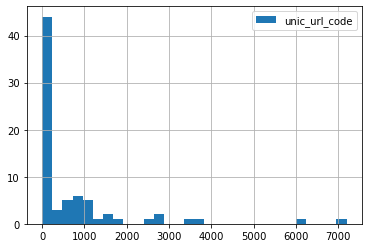

In [92]:
data.unic_url_code.value_counts().hist(legend=True, bins=30)

## Вывод  URL_TA
из адреса страницы мы извлекли числовой идентификатор, который не уникален , но определенно в нем чтото зашифровано...город, комбинация кухни?
я конечно создал параметр, в названии которого фигурирует "unic", не обращаем внимание))

## 9.ID_TA 

In [93]:
data['ID_TA'][1]

'd6674944'

In [94]:
data['unic_id_ta'] = data['ID_TA'].apply(
    lambda x: str(x)[1:]).astype('float64')
data[['unic_id_ta', 'ID_TA']]
# получилось все корректно

,unic_id_ta,ID_TA
0,10746918.0,d10746918
1,6674944.0,d6674944
2,13129638.0,d13129638
3,680417.0,d680417
4,1112354.0,d1112354
...,...,...
49995,2104414.0,d2104414
49996,1800036.0,d1800036
49997,947615.0,d947615
49998,1100838.0,d1100838


In [95]:
data.unic_id_ta.value_counts()

1568045.0     2
12488993.0    2
9877640.0     2
11999956.0    2
793170.0      2
             ..
12946201.0    1
3317055.0     1
1124064.0     1
5826997.0     1
720896.0      1
Name: unic_id_ta, Length: 49963, dtype: int64

## Вывод ID_TA
Получили идентификатор ресторана.

# Финальная подготовка данных 

In [96]:
s = data.isnull().sum()
s[s > 1]

Price_range    17361
dtype: int64

In [97]:
# проверяем заполнение
display(data.describe().head(1))

,Ranking,Number_of_reviews,Sample,Rating,Franchise,No_Price,Price_value,City_rest,mean_City_rank,norming_rank,...,Swiss,Welsh,Filipino,No_reviews,Dates_count,last_review,between_reviews,single_review,unic_url_code,unic_id_ta
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0


In [98]:
data.columns

Index(['Restaurant_id', 'Cuisine_style', 'Ranking', 'Price_range',
       'Number_of_reviews', 'Reviews', 'URL_TA', 'ID_TA', 'Sample', 'Rating',
       ...
       'Welsh', 'Filipino', 'No_reviews', 'Review_dates', 'Dates_count',
       'last_review', 'between_reviews', 'single_review', 'unic_url_code',
       'unic_id_ta'],
      dtype='object', length=184)

In [99]:
data['Cuisine_style'] = data['Cuisine_style'].apply(lambda x: str(x))
#data = pd.get_dummies(data, columns=[ 'Cuisine_style'], dummy_na=False)
data.drop(['Restaurant_id', 'City', 'Cuisine_style', 'Price_range', 'Reviews', 'URL_TA', 'ID_TA',
           'Review_dates', 'unic_id_ta', 'unic_url_code'], axis=1, inplace=True, errors='ignore')

In [100]:
data_new = data.copy()


def get_stat_dif(column):
    cols = data[data['Sample'] == 1].loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data[data['Sample'] == 1].loc[data_new.loc[:, column] == comb[0], 'Rating'],
                     data[data['Sample'] == 1].loc[data_new.loc[:, column] == comb[1], 'Rating']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
        else:
            print('Не найдены статистически значимые различия для колонки', column)
            break


for col in data_new.columns.tolist():
    get_stat_dif(col)

Не найдены статистически значимые различия для колонки Ranking
Не найдены статистически значимые различия для колонки Number_of_reviews
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различи

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Не найдены статистически значимые различия для колонки Minority Chinese
Не найдены статистически значимые различия для колонки Egyptian
Найдены статистически значимые различия для колонки Vietnamese
Найдены статистически значимые различия для колонки Croatian
Найдены статистически значимые различия для колонки Bar
Не найдены статистически значимые различия для колонки Cambodian
Найдены статистически значимые различия для колонки Vegan Options
Найдены статистически значимые различия для колонки Latin
Не найдены статистически значимые различия для колонки Persian
Не найдены статистически значимые различия для колонки Central Asian
Не найдены статистически значимые различия для колонки Israeli
Не найдены статистически значимые различия для колонки Romanian
Найдены статистически значимые различия для колонки Seafood
Найдены статистически значимые различия для колонки Soups
Найдены статистически значимые различия для колонки Street Food
Найдены статистически значимые различия для колонки Gl

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Не найдены статистически значимые различия для колонки Indonesian
Не найдены статистически значимые различия для колонки Sri Lankan
Найдены статистически значимые различия для колонки Healthy
Найдены статистически значимые различия для колонки Chinese
Найдены статистически значимые различия для колонки European
Не найдены статистически значимые различия для колонки Tibetan
Найдены статистически значимые различия для колонки German
Не найдены статистически значимые различия для колонки Latvian


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Не найдены статистически значимые различия для колонки Taiwanese
Найдены статистически значимые различия для колонки Danish
Не найдены статистически значимые различия для колонки Australian
Не найдены статистически значимые различия для колонки Grill
Не найдены статистически значимые различия для колонки Singaporean
Не найдены статистически значимые различия для колонки Native American
Найдены статистически значимые различия для колонки Portuguese
Не найдены статистически значимые различия для колонки British
Не найдены статистически значимые различия для колонки Azerbaijani
Не найдены статистически значимые различия для колонки Czech
Не найдены статистически значимые различия для колонки Pub
Не найдены статистически значимые различия для колонки Barbecue
Найдены статистически значимые различия для колонки Turkish
Не найдены статистически значимые различия для колонки Arabic
Не найдены статистически значимые различия для колонки Jamaican
Не найдены статистически значимые различия для к

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Не найдены статистически значимые различия для колонки Salvadoran
Найдены статистически значимые различия для колонки Hawaiian
Найдены статистически значимые различия для колонки Central European
Найдены статистически значимые различия для колонки Scandinavian
Не найдены статистически значимые различия для колонки Albanian
Найдены статистически значимые различия для колонки Middle Eastern
Найдены статистически значимые различия для колонки Dutch
Найдены статистически значимые различия для колонки American
Найдены статистически значимые различия для колонки New Zealand
Не найдены статистически значимые различия для колонки Xinjiang


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Не найдены статистически значимые различия для колонки Norwegian
Найдены статистически значимые различия для колонки Brew Pub
Найдены статистически значимые различия для колонки South American
Не найдены статистически значимые различия для колонки Afghani
Найдены статистически значимые различия для колонки Cafe
Не найдены статистически значимые различия для колонки Indian
Не найдены статистически значимые различия для колонки Brazilian
Найдены статистически значимые различия для колонки African
Найдены статистически значимые различия для колонки Wine Bar
Найдены статистически значимые различия для колонки Gastropub
Найдены статистически значимые различия для колонки Hungarian
Найдены статистически значимые различия для колонки Other
Не найдены статистически значимые различия для колонки Colombian
Не найдены статистически значимые различия для колонки Bangladeshi
Не найдены статистически значимые различия для колонки Steakhouse
Найдены статистически значимые различия для колонки Uzbek
Н

In [101]:
data_new = data.copy()
data_new = pd.get_dummies(data_new, columns=['Price_value', ], dummy_na=False)
data_new.drop(['Price_value_3.0', 'No_reviews', 'Franchise', 'No_Cuisine_style', 'City_rest', 'mean_City_rank', 'Cuisine_quant', 'Dates_count', 'single_review', 'City_nan', 'City_paris',
               'City_london', 'City_helsinki', 'City_hamburg', 'City_zurich', 'City_geneva', 'City_luxembourg', 'City_bratislava', 'City_copenhagen'], axis=1, inplace=True, errors='ignore')
data_new.columns
columns_list = data_new.columns.tolist()
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 158 entries, Ranking to Price_value_2.0
dtypes: float64(6), int64(128), uint8(24)
memory usage: 52.3 MB


<AxesSubplot:>

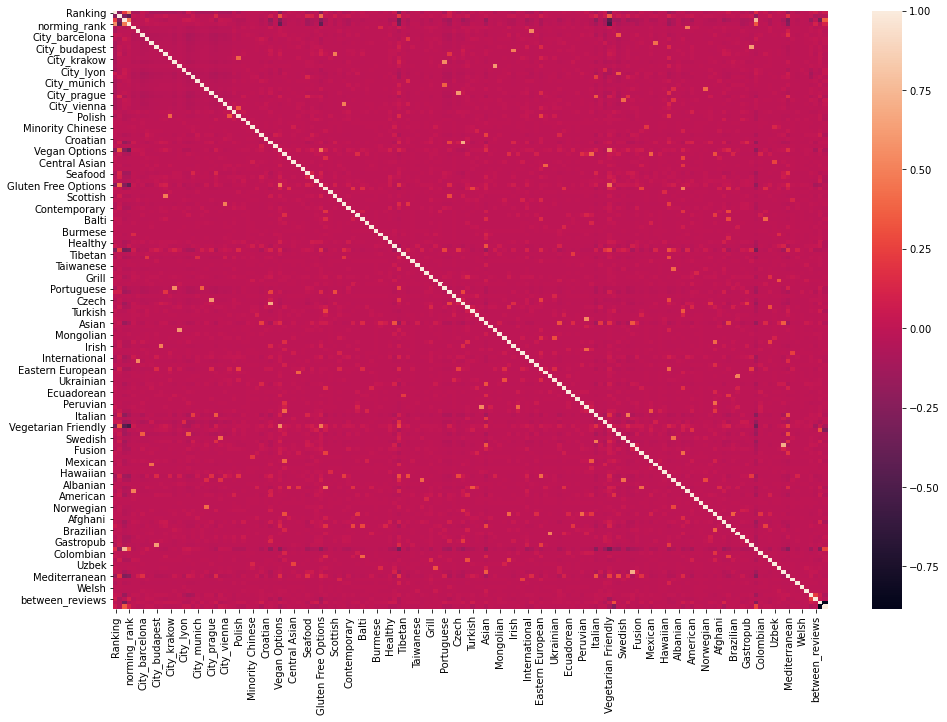

In [102]:
plt.rcParams['figure.figsize'] = (16, 11)
sns.heatmap(data_new.drop(['Sample', 'Rating'], axis=1).corr(),)

In [103]:
# стандартизируем все столбцы кроме целевой и Sample
for i in list(data_new.columns):
    if i not in ['Rating', 'Sample']:
        scaler = StandardScaler()
        scaler.fit(data_new[[i]])
        data_new[i] = scaler.transform(data_new[[i]])

In [104]:
train_data = data_new.query('Sample == 1').drop(['Sample'], axis=1)
test_data = data_new.query('Sample == 0').drop(['Sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [105]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [106]:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 157), (40000, 157), (40000, 156), (32000, 156), (8000, 156))

In [107]:
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [108]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [109]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20309125


<AxesSubplot:>

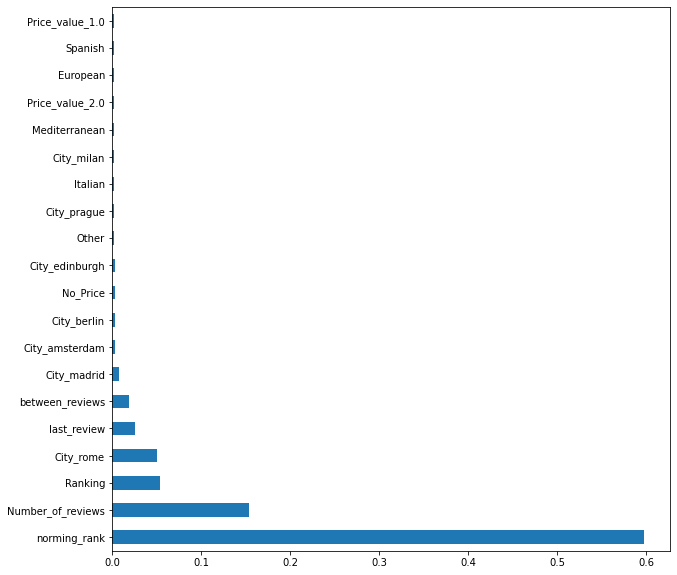

In [110]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission 

In [111]:
train_data = data_new.query('Sample == 1').drop(['Sample'], axis=1)
test_data = data_new.query('Sample == 0').drop(['Sample', 'Rating'], axis=1)
y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [112]:
sample_submission.shape, test_data.shape, X.shape, y.shape

((10000, 2), (10000, 156), (40000, 156), (40000,))

In [ ]:
model.fit(X, y)

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)